In [1]:
import numpy as np
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.mixture import GaussianMixture
import tensorflow_probability as tfp
from keras.layers import Lambda, Input, Dense
from keras.models import Model
from keras.datasets import mnist
from keras.losses import mse, binary_crossentropy
from keras.utils import plot_model
from keras import backend as K
from tensorflow.keras import layers
from sklearn.decomposition import PCA

import numpy as np
import matplotlib.pyplot as plt
import os


Using TensorFlow backend.


In [2]:
def write_tsv(array, name):
    if len(array.shape) == 2:
        l, w = array.shape
    else:
        array = array.reshape(-1,1)
        l, w = array.shape
    
    with open(name,'w') as f:
        for i in range(l):
            for j in range(w):
                f.write(str(array[i,j]))
                if j != w-1:
                    f.write('\t')
            f.write('\n')
            

In [3]:
dataset_name = 'MNIST'
#dataset_name = 'synthetic'

In [4]:
if dataset_name == 'MNIST':
    (x_train, _), _ = tf.keras.datasets.mnist.load_data()
    x_train = x_train.reshape(60000, 784).astype('float32') / 255
elif dataset_name == 'synthetic':
    all_data= np.load('traj.npy').astype(np.float32)
    all_data= (all_data - all_data.mean())/all_data.std()
    np.random.shuffle(all_data)
    train_size = 100000
    x_train = all_data[:train_size]
    x_test = all_data[train_size:train_size*2]
    gm = GaussianMixture(n_components=8)
    clusters = gm.fit_predict(x_train)
    sns.distplot(x_train,label='train')
    sns.distplot(x_test,label='test')
    plt.legend()
else:
    raise Exception('Unknown Dataset')

In [5]:
class Sampling(layers.Layer):
  """Uses (z_mean, z_log_var) to sample z, the vector encoding a digit."""

  def call(self, z_mean, z_log_var):
    batch = tf.shape(z_mean)[0]
    dim = tf.shape(z_mean)[1]
    epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
    return z_mean + tf.exp(0.5 * z_log_var) * epsilon


class VAE(tf.keras.Model):
    def __init__(self,
                 original_dim,
                 intermediate_dim, 
                 latent_dim,
                 output_act):
        super(VAE, self).__init__()
        self.latent_dim = latent_dim
        self.encoder_1 = tf.keras.layers.Dense(intermediate_dim, activation=tf.nn.relu)
        self.log_var = tf.keras.layers.Dense(self.latent_dim)
        self.mean_layer = tf.keras.layers.Dense(self.latent_dim)
        self.decoder_1 = tf.keras.layers.Dense(intermediate_dim, activation=tf.nn.relu)
        self.decoder_2 = tf.keras.layers.Dense(original_dim, activation=output_act)
        self.sampling = Sampling()

    def call(self, inputs, recon_alpha):
        x = self.encoder_1(inputs)
        log_var = self.log_var(x)
        u = self.mean_layer(x)
        q_z = self.sampling(u,log_var)
        x = self.decoder_1(q_z)
        x = self.decoder_2(x)
        recon_loss = tf.reduce_sum((inputs-x)**2,1)
        KL_w =  -0.5 * tf.reduce_sum( 1 + log_var - tf.exp(log_var) - tf.square(u) , 1)
        return tf.reduce_mean(recon_loss * recon_alpha  + KL_w), tf.reduce_mean(recon_loss)
    
    
    def get_latent(self, inputs):
        x = self.encoder_1(inputs)
        log_var = self.log_var(x)
        u = self.mean_layer(x)
        q_z = self.sampling(u,log_var)
        return q_z
    
    def get_sample(self,q_z):
        x = self.decoder_1(q_z)
        x = self.decoder_2(x)
        return x

In [6]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
loss_metric = tf.keras.metrics.Mean()

In [7]:
train_dataset = tf.data.Dataset.from_tensor_slices(x_train)
train_dataset = train_dataset.shuffle(buffer_size=1024).batch(128)

In [8]:
if dataset_name == 'MNIST':
    original_dim=784
    intermediate_dim = 128
    vae = VAE(original_dim=original_dim, intermediate_dim=intermediate_dim, latent_dim=128,output_act="sigmoid")
    input_size = 28
    epoch_number = 8
    recon_alpha = 1
else :
    original_dim=1
    intermediate_dim = 128
    vae = VAE(original_dim=original_dim, intermediate_dim=intermediate_dim, latent_dim=2,output_act=None)
    input_size = 1
    epoch_number = 2
    recon_alpha = 10

In [9]:
# Iterate over epochs.
for epoch in range(epoch_number):
    print('Start of epoch %d' % (epoch,))
    for step, x_batch_train in enumerate(train_dataset):
        with tf.GradientTape() as tape:
            loss, recon_loss= vae(x_batch_train,recon_alpha = recon_alpha)
        grads = tape.gradient(loss, vae.trainable_weights)
        optimizer.apply_gradients(zip(grads, vae.trainable_weights))
        loss_metric(loss)

        if step % 100 == 0:
            print('step %s: mean loss = %s' % (step, loss_metric.result().numpy()),recon_loss.numpy())
            
            

Start of epoch 0
step 0: mean loss = 195.92258 188.34723
step 100: mean loss = 74.43406 55.65633
step 200: mean loss = 64.63099 49.74685
step 300: mean loss = 60.26596 47.050835
step 400: mean loss = 57.40228 42.203423
Start of epoch 1
step 0: mean loss = 55.76983 40.42465
step 100: mean loss = 53.891647 38.42573
step 200: mean loss = 52.48388 35.576576
step 300: mean loss = 51.292107 36.19835
step 400: mean loss = 50.318584 34.25411
Start of epoch 2
step 0: mean loss = 49.701138 33.522682
step 100: mean loss = 48.949593 34.106796
step 200: mean loss = 48.33046 32.57572
step 300: mean loss = 47.76078 33.574394
step 400: mean loss = 47.2684 32.94929
Start of epoch 3
step 0: mean loss = 46.92958 31.522745
step 100: mean loss = 46.488052 31.395847
step 200: mean loss = 46.113068 32.389793
step 300: mean loss = 45.74254 30.434168
step 400: mean loss = 45.408276 31.854668
Start of epoch 4
step 0: mean loss = 45.169437 31.352818
step 100: mean loss = 44.83925 29.335098
step 200: mean loss = 

In [ ]:
import numpy as np
palette = np.array([[  0,   0,   0],   # black
                    [255,   0,   0],   # red
                    [  0, 255,   0],   # green
                    [  0,   0, 255],   # blue
                    [255, 255, 255]])  # white
I = np.array([[ 0, 1, 2, 0],    # 2 rows, 4 columns, 1 channel
              [ 0, 3, 4, 0]])


In [10]:
from scipy.stats import norm
batch_size = 1
n = 20
# figure with 20x20 digits
input_size = input_size
figure = np.zeros((input_size * n, input_size * n))
# Construct grid of latent variable values
grid_x = norm.ppf(np.linspace(0.05, 0.95, n))
grid_y = norm.ppf(np.linspace(0.05, 0.95, n))

# decode for each square in the grid
for i, yi in enumerate(grid_x):
    for j, xi in enumerate(grid_y):
        z_sample = np.array([[xi, yi]])
        z_sample = np.tile(z_sample, batch_size).reshape(batch_size, 2)
        x_decoded = vae.get_sample(z_sample)
        recon_sample = x_decoded[0].numpy().reshape(input_size, input_size)
        figure[i * input_size: (i + 1) * input_size,
               j * input_size: (j + 1) * input_size] = recon_sample

plt.figure(figsize=(16, 16))
#plt.matshow(figure, cmap='gnuplot2')
plt.imshow(figure, cmap='bone')
plt.colorbar()
plt.savefig('vae/vae_decoded_latent_' + dataset_name)
plt.show()  


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.



InvalidArgumentError: Matrix size-incompatible: In[0]: [1,2], In[1]: [128,128] [Op:MatMul]

In [11]:
if dataset_name == "MNIST":
    (_, _), (x_test,label_test) = tf.keras.datasets.mnist.load_data()
    x_test = x_test.reshape(10000, 784).astype('float32') / 255
    z = vae.get_latent(x_test)
    write_tsv(z[:1000].numpy().astype(np.float16),'vae_mnist_z.tsv')
    write_tsv(label_test[:1000],'vae_mnist_label.tsv')
else:
    label_test = gm.predict(x_test)
    z = vae.get_latent(x_test)
    write_tsv(z[:10000].numpy().astype(np.float32),'synthetic_z.tsv')
    write_tsv(label_test[:10000],'synthetic_label.tsv')

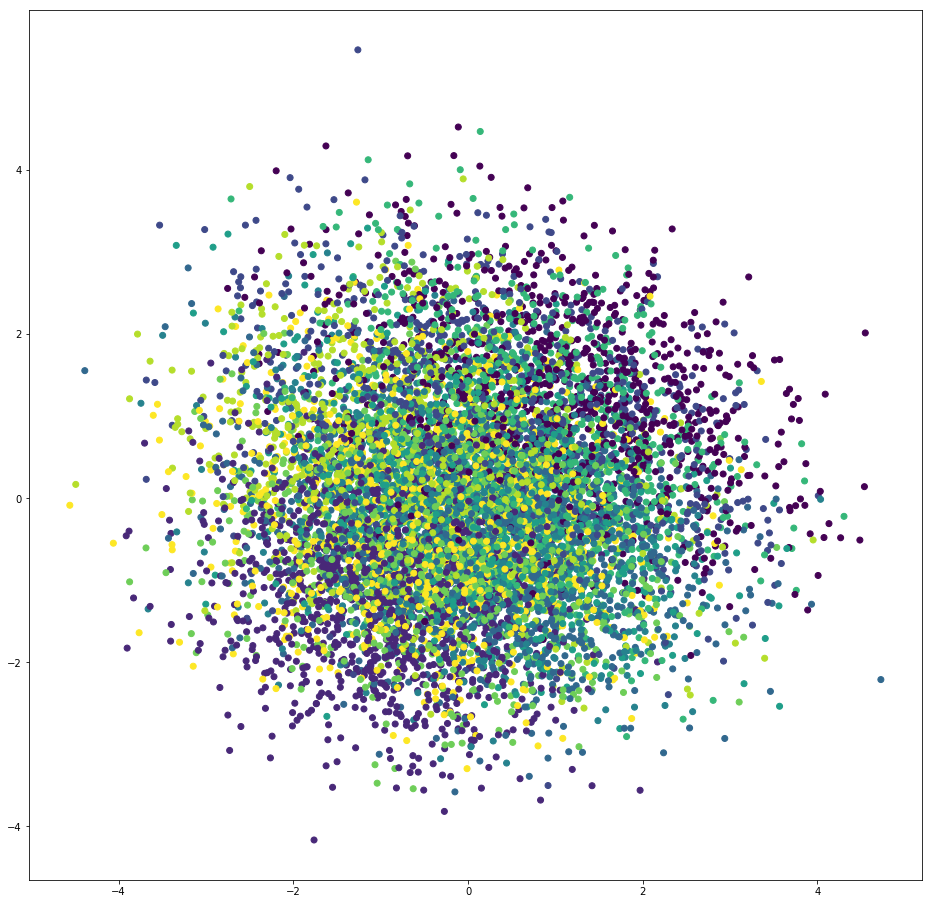

In [12]:
plt.figure(figsize=(16,16))
pca = PCA(n_components=2)
z_tranform = pca.fit_transform(z)
plt.scatter(z_tranform[:,0],z_tranform[:,1],c=label_test)
plt.savefig('vae/vae_encoded_latent_' + dataset_name)